# Example Notebook on how to use flarenet

In [1]:
%matplotlib widget

In [2]:
import pandas as pd
from astropy.io import ascii
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from flarenet.utils import normalize_flux
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import warnings

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import flarenet
flarenet.__path__

['/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet']

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.model_selection import RandomizedSearchCV

In [6]:
tf.config.list_physical_devices('GPU')

[]

## Create the training data

Note the training dataset is built off of 'quiet flares' which vera vetted by eye. The TIC and sectors are stored in:
flarenet/supplemental_files/ids_sectors_quietlcs.txt

In [56]:
'''def make_injected_flare_trainingset(num_lcs : int = 1, 
                                    save_plots : bool = False,
                                    flare_frac : float = 0.1,
                                    output_dir : str = "training_data/injected_flares/",
                                    add_pulsation : bool = False,
                                    add_rrlyrae : bool = False,
                                    ):'''

# I ran this 3 times, once with injecting flares (and an 'asteroid'), 
#    one with additional pulsations, and one with rr lyrae-like variability for a total of 30 lightcurves
#    Each lightkurve is broken up into 2 orbits, so it is actually 60 training files total 

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    flarenet.make_injected_flare_trainingset(num_lcs=20, save_plots=True, add_rrlyrae=False, add_pulsation=True, cloud=True)

Creating flares for 300970893 Sector 63
Creating flares for 41488282 Sector 33
Creating flares for 160424054 Sector 49
Creating flares for 149059708 Sector 29
Creating flares for 300443029 Sector 29
Creating flares for 141029712 Sector 62
Creating flares for 219780306 Sector 56
Creating flares for 268393135 Sector 52
Creating flares for 1758607 Sector 46
Creating flares for 4300064 Sector 60


Creating flares for 150064391 Sector 34
Creating flares for 219814166 Sector 52
Creating flares for 233682504 Sector 53
Creating flares for 219780306 Sector 50
Creating flares for 219778329 Sector 58
Creating flares for 219012849 Sector 60


Creating flares for 299943844 Sector 63
Creating flares for 61115796 Sector 43
Creating flares for 141609430 Sector 63
Creating flares for 6890541 Sector 45


/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:26: RuntimeWarning: overflow encountered in exp
  * np.exp(-D2 * t+ ((B / C) + (D2 * C / 2)) ** 2) * special.erfc(((B - t) / C) + (C * D2 / 2)))
/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:25: RuntimeWarning: invalid value encountered in multiply
  * special.erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2
/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:24: RuntimeWarning: overflow encountered in exp
  eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:24: RuntimeWarning: invalid value encountered in multiply
  eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)


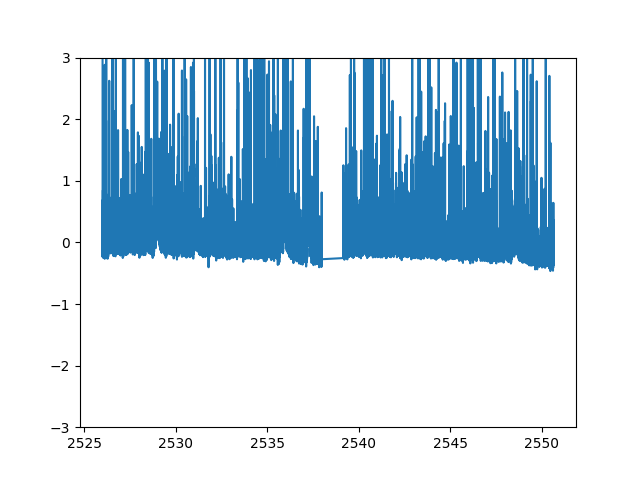

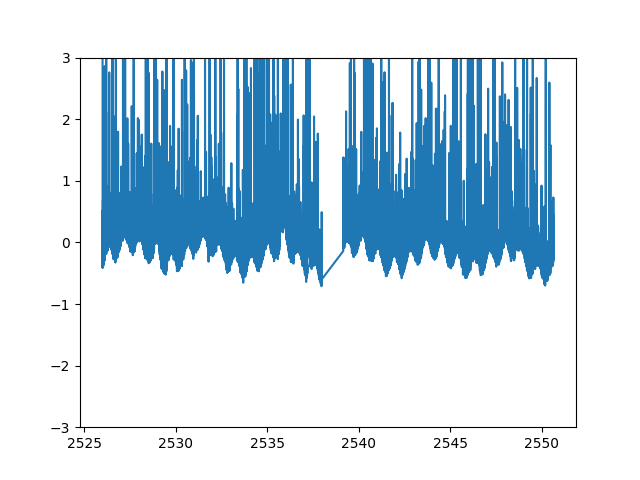

In [59]:
# This is ust an example what a lc with added pulsations looks like
mytpf = flarenet.TessStar("TIC 61101267", sector=45, exptime=20, cloud=False, download_dir='tpfs/')
mytpf.get_metadata()
flares, params = mytpf.generate_flares(num_flares=100) 

threshold = (mytpf.lc_std / np.nanmedian(mytpf.lc.flux)).value
mytpf.get_flare_flags(flares, threshold=threshold) 

mytpf.inject_flares(flares) # inject them onto the lc

#Plot before pulsations
fig, ax = plt.subplots(1)
plt.plot(mytpf.lc.time.value, mytpf.flux_with_flares)
plt.ylim(-3,3)
plt.show()

mytpf.inject_stellar_pulsations()
# Plot after pulsations
fig, ax = plt.subplots(1)
plt.plot(mytpf.lc.time.value, mytpf.flux_with_flares)
plt.ylim(-3,3)
plt.show()

/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:24: RuntimeWarning: overflow encountered in exp
  eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:24: RuntimeWarning: invalid value encountered in multiply
  eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:26: RuntimeWarning: overflow encountered in exp
  * np.exp(-D2 * t+ ((B / C) + (D2 * C / 2)) ** 2) * special.erfc(((B - t) / C) + (C * D2 / 2)))
/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/flare_model.py:25: RuntimeWarning: invalid value encountered in multiply
  * special.erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2


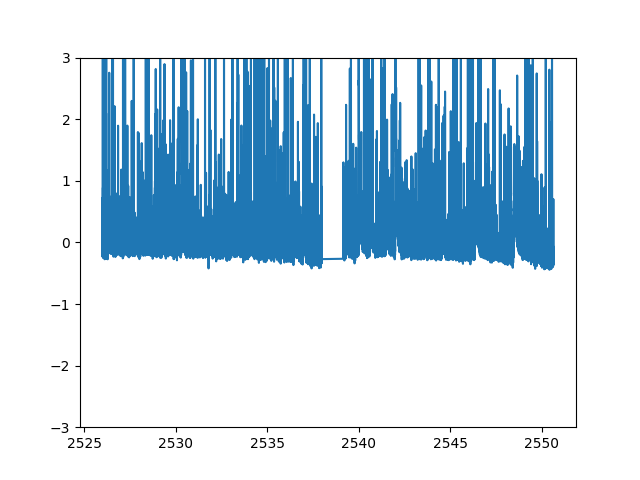

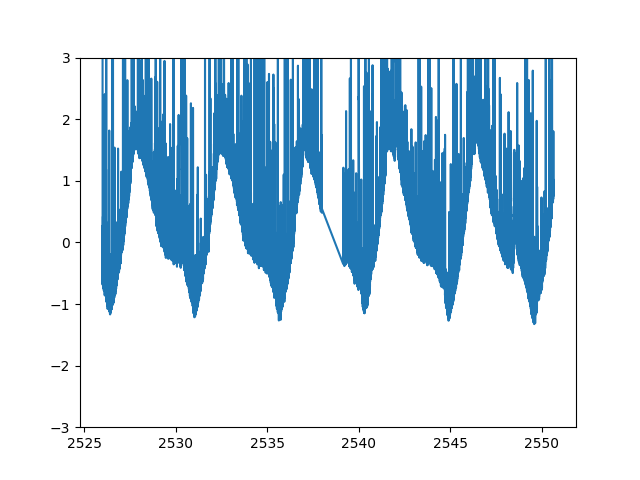

In [60]:
# Just an example of a lc with rr-lyrae like variability looks like
mytpf = flarenet.TessStar("TIC 61101267", sector=45, exptime=20, cloud=False, download_dir='tpfs/')
mytpf.get_metadata()
flares, params = mytpf.generate_flares(num_flares=100) 

threshold = (mytpf.lc_std / np.nanmedian(mytpf.lc.flux)).value
mytpf.get_flare_flags(flares, threshold=threshold) 

mytpf.inject_flares(flares) # inject them onto the lc

#Plot before pulsations
fig, ax = plt.subplots(1)
plt.plot(mytpf.lc.time.value, mytpf.flux_with_flares)
plt.ylim(-3,3)
plt.show()

mytpf.inject_rr_lyrae()
# Plot after pulsations
fig, ax = plt.subplots(1)
plt.plot(mytpf.lc.time.value, mytpf.flux_with_flares)
plt.ylim(-3,3)
plt.show()

In [61]:
import glob
file_list = glob.glob('flarenet/training_data/injected_flares/*.csv')
print(len(file_list))
for file in file_list:
    dat = pd.read_csv(file)
    print(f"{file} : {np.nanmedian(dat['flux_with_flares'])}")

120
flarenet/training_data/injected_flares/TIC 38846515_34_2_data_rrlyrae.csv : 0.397656205483512
flarenet/training_data/injected_flares/TIC 229747848_56_2_data.csv : -0.04020683761568365
flarenet/training_data/injected_flares/TIC 219780306_56_1_data_pulsations.csv : -0.0917772658073498
flarenet/training_data/injected_flares/TIC 150064391_34_1_data_pulsations.csv : -0.1804716396379638
flarenet/training_data/injected_flares/TIC 233682504_53_2_data_pulsations.csv : -0.0091811281305647
flarenet/training_data/injected_flares/TIC 1758607_46_1_data_pulsations.csv : -0.0655047072297701
flarenet/training_data/injected_flares/TIC 149990841_39_2_data.csv : -0.06436428906633646
flarenet/training_data/injected_flares/TIC 149059708_29_1_data_pulsations.csv : -0.09883481711008545
flarenet/training_data/injected_flares/TIC 142019343_61_1_data_rrlyrae.csv : -0.0608026482159084
flarenet/training_data/injected_flares/TIC 243315463_41_1_data_rrlyrae.csv : 0.0171084329449433
flarenet/training_data/injecte

# Train a basic model without extra scaling of the data

This is a bit cumbersome at the moment. Basically you need to create a flarenet object. 
If you want to change the window size or data scaling, it needs to happen on initialization. This is so that the rest of the functions do the same thing (the training and testing have the same window length, for example.)

In [62]:
import flarenet

In [160]:
window_size=500
fn = flarenet.flarenet(verbose=True,
                      scaling = None,
                      #window_size = 500, 
                      )

# Create your training dataset. 
# The size of drop_frac matters for training. 
#    This sets the fraction of total data points to skip, so a bigger number means fewer training samples
fn.create_training_dataset(data_dir = 'training_data/injected_flares',
                                drop_frac=0.5, 
                                )
fn.training_files[:10]

Found 120 training files


['/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 38846515_34_2_data_rrlyrae.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 229747848_56_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 219780306_56_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 150064391_34_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 233682504_53_2_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 1758607_46_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149990841_39_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149059708_29_1_data_pulsations.csv',
 '/U

Samples of minority class samples: 5105
Total Samples: 52182
Valid indices: 10210


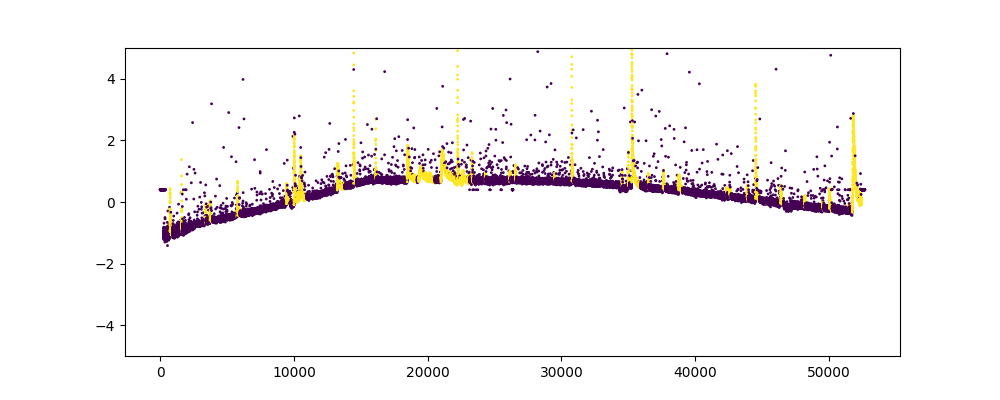

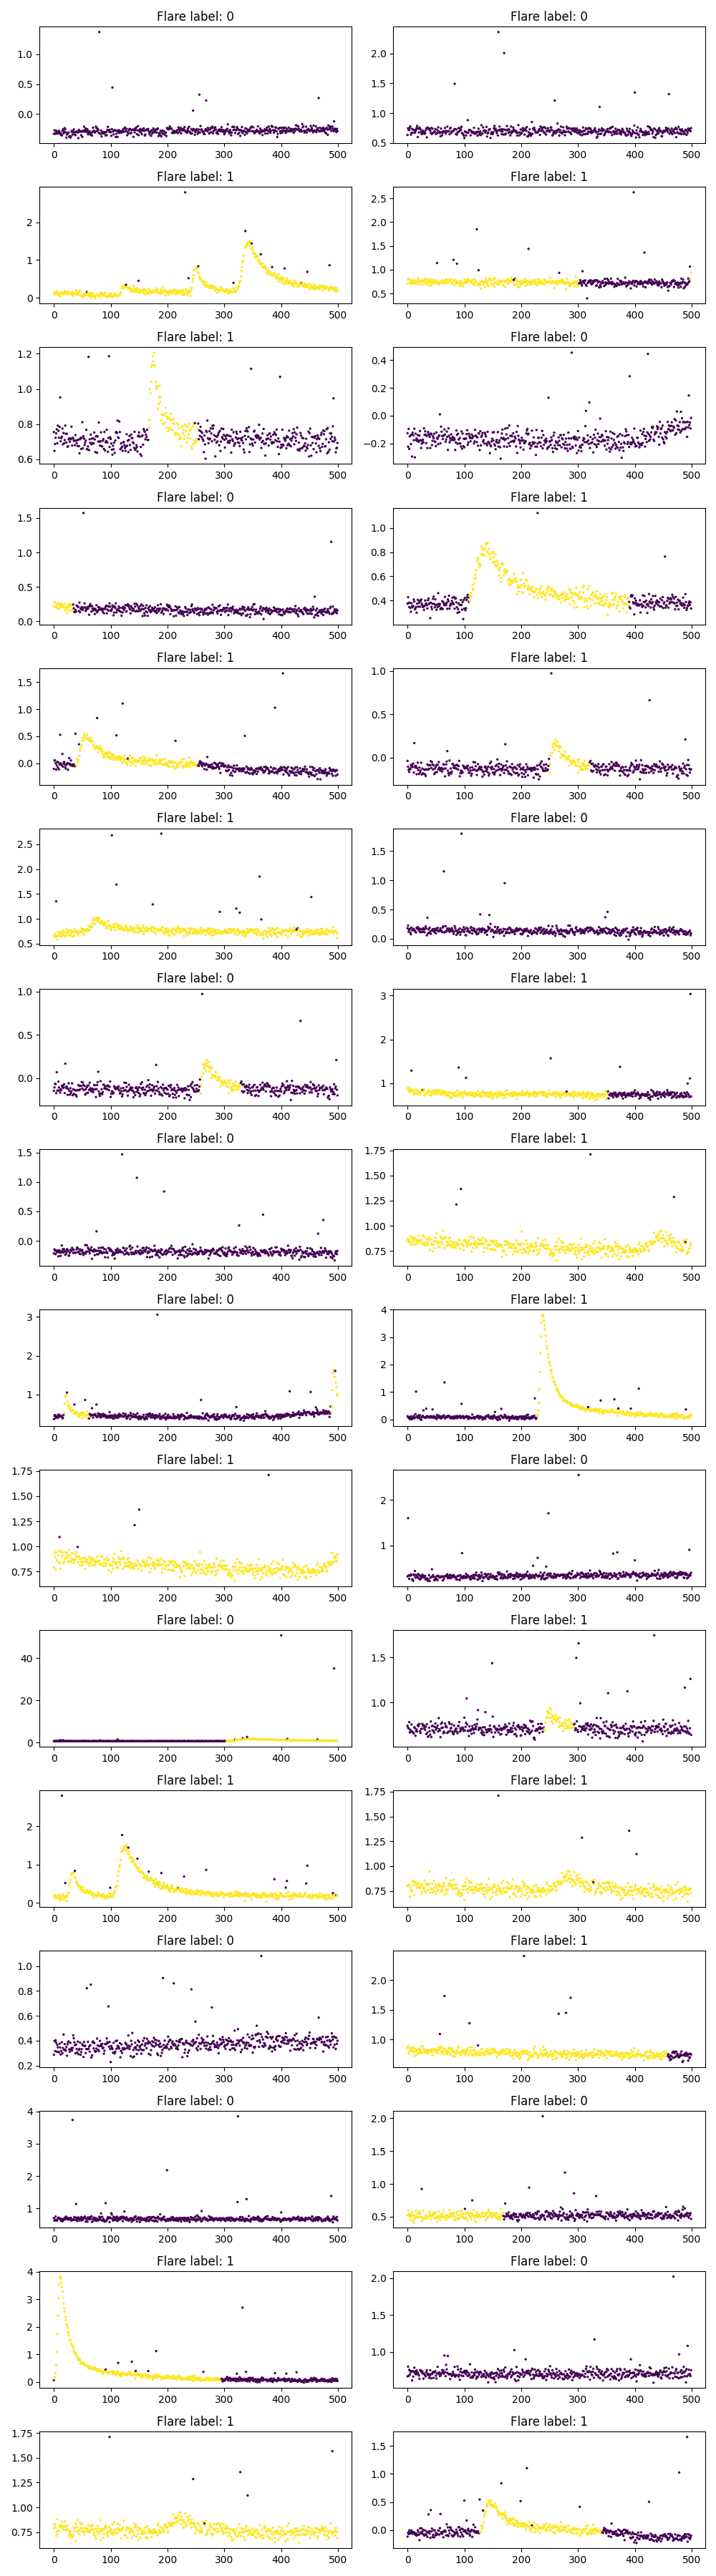

In [161]:
fn.visualize_input()

In [162]:
# This is just a check to see how the data generator works. This happens inside create_training_dataset

dataset = tf.data.Dataset.from_generator(
    lambda: fn._prepare_training_generator(fn.training_files),
    output_signature=(
        {
            "inputA": tf.TensorSpec(shape=(None, fn.window_size, 1), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

In [163]:
dataset

<_FlatMapDataset element_spec=({'inputA': TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [164]:
#for sample in dataset.take(2):
#    print(sample)

In [165]:
# You can add a string to an existing keras model or it will generate a new model with the default parameters
# Note it is on you to make sure the data shapes are correct 
history = fn.train_model(epochs=1)

Generating new nn model


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputA (InputLayer)             │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_138 (Conv1D)             │ (None, 500, 16)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_139 (Conv1D)             │ (None, 500, 16)        │         3,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_140 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_141 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_142 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_143 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 500, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │       512,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,633 (2.01 MB)

 Trainable params: 527,601 (2.01 MB)

 Non-trainable params: 32 (128.00 B)

None


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


initilizing generator for /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 38846515_34_2_data_rrlyrae.csv
    319/Unknown 7s 19ms/step - accuracy: 0.6383 - loss: 0.7235initilizing generator for /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 229747848_56_2_data.c
    549/Unknown 12s 19ms/step - accuracy: 0.6629 - loss: 0.6949initilizing generator for /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 219780306_56_1_data_pulsations.csv
    947/Unknown 20s 19ms/step - accuracy: 0.6999 - loss: 0.6407initilizing generator for /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 150064391_34_1_data_pulsations.csv
   1524/Unknown 30s 19ms/step - accuracy: 0.7282 - loss: 0.5928initilizing generator for /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 233682504_53_2_data_pulsations.csv
   1766/Unknown 

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [166]:
fn.model.save('alpha_test/alpha_test_noscaling_model.keras')

# Get a lightcurve to test on
Note this is just a sanity check, Need to implement proper validation and testing later. 
I have manually made this prediction file using the make_prediction_dataset() function. This is AU Mic

In [167]:
# These are the orbit files. These are CSV files that have split up a sector into 2 orbits and normalized flux. 
#     The training data orbit files have extra columns with the flux with flares, but not here.
test_o1 = pd.read_csv('flarenet/prediction_data/TIC 441420236_27_1_data.csv')
test_o2 = pd.read_csv('flarenet/prediction_data/TIC 441420236_27_2_data.csv')
test = pd.concat([test_o1, test_o2])
test.head()

time          flux    flux_err  quality  crArr  normalized_flux
0  2036.283452  266033.59375  120.750626      0.0    0.0        -0.812225
1  2036.283684  266085.81250  120.773315      0.0    0.0        -0.792427
2  2036.283915  265954.62500  120.745430      0.0    0.0        -0.842165
3  2036.284147  265992.00000  120.746674      0.0    0.0        -0.827995
4  2036.284378  266262.90625  120.818077      0.0    0.0        -0.725284

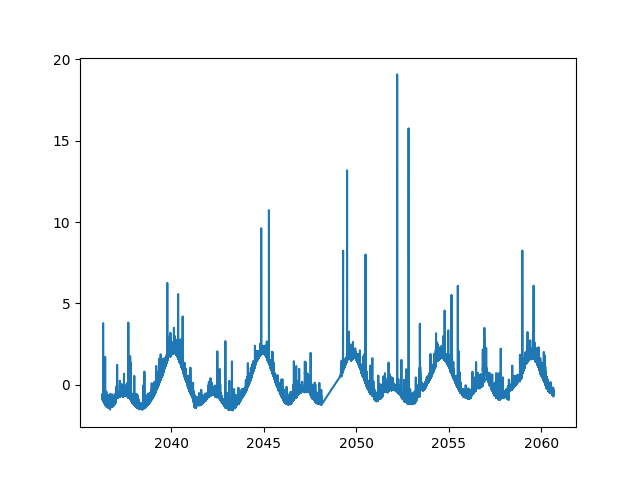

In [168]:
# Just taking a look at the lc. This is a very active star!
plt.figure()
plt.plot(test['time'], test['normalized_flux'])
plt.show()

In [169]:
# The predictions only happen on one orbit file at a time right now. This may be too confusing. 
fn.create_prediction_dataset('flarenet/prediction_data/TIC 441420236_27_1_data.csv')
fn.prediction_dataset # Just printing it to see the shapes. 

Making predictions for flarenet/prediction_data/TIC 441420236_27_1_data.csv 


<_FlatMapDataset element_spec=({'inputA': TensorSpec(shape=(1, 500, 1), dtype=tf.float32, name=None)},)>

In [170]:
# If you just trained a model, you don't actually have to pass a string to a model, but I am importing one I already trained here. 
fn.predict_with_model('alpha_test/alpha_test_noscaling_model.keras')

Loading model from alpha_test/alpha_test_noscaling_model.keras
initilizing generator for flarenet/prediction_data/TIC 441420236_27_1_data.csv
    178/Unknown 0s 849us/step

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


51196/51196 ━━━━━━━━━━━━━━━━━━━━ 47s 906us/step


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Here is where it gets really dicey. The model saves out a padded a filled lightcurve as a npy file. The predictions will be on this file as there are no gaps. 

In [171]:
# The prediction happens for every
pred_data = pd.read_csv('flarenet/prediction_data/nn_input/TIC 441420236_27_1_data.npy')
pred_data

Unnamed: 0         time          flux    flux_err  quality  crArr  \
0             498  2036.225813  266638.71875  121.158333    128.0    0.0   
1             496  2036.226045  266638.71875  121.158333    128.0    0.0   
2             494  2036.226276  266638.71875  121.158333    128.0    0.0   
3             492  2036.226508  266638.71875  121.158333    128.0    0.0   
4             490  2036.226739  266638.71875  121.158333    128.0    0.0   
...           ...          ...           ...         ...      ...    ...   
51691         491  2048.191157  266638.71875  121.158333    128.0    0.0   
51692         493  2048.191389  266638.71875  121.158333    128.0    0.0   
51693         495  2048.191620  266638.71875  121.158333    128.0    0.0   
51694         497  2048.191852  266638.71875  121.158333    128.0    0.0   
51695         499  2048.192083  266638.71875  121.158333    128.0    0.0   

       normalized_flux  filled  flareArr  
0            -0.582798     1.0       0.0  
1            -0.582798     1.0       0.0  
2            -0.582798     1.0       0.0  
3            -0.582798     1.0       0.0  
4            -0.582798     1.0       0.0  
...                ...     ...       ...  
51691        -0.582798     1.0       0.0  
51692        -0.582798     1.0       0.0  
51693        -0.582798     1.0       0.0  
51694        -0.582798     1.0       0.0  
51695        -0.582798     1.0       0.0  

[51696 rows x 9 columns]

In [172]:
# No predictions happen on the first window_size/2 and last window_size/2 data points. 
# These are just padded for the model. If we didn't do this, we couldn't find flares at the start and end of the sectors. 
len(pred_data), len(fn.preds), sum(pred_data['filled'])

(51696, 51196, 547.0)

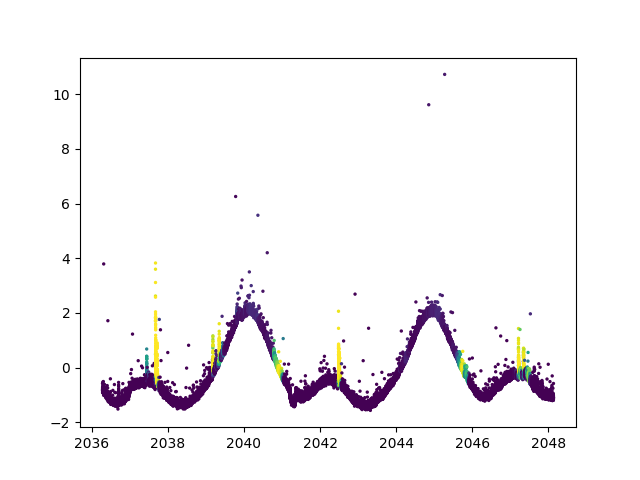

In [173]:
plt.figure()
# I'll have to better program this so users don't have to worry about this slicing confusion. 
plt.scatter(pred_data['time'].values[250:-250], pred_data['normalized_flux'].values[250:-250], c=fn.preds, s=2)
plt.show()

# Train a basic model with MinMaxScaling

I repeat the same code as above with different scaling. 

In [150]:
window_size=500
fn = flarenet.flarenet(verbose=False,
                      scaling = "MinMax",)
fn.create_training_dataset(data_dir = 'training_data/injected_flares',
                                drop_frac=0.5, 
                                )
fn.training_files[:10]

Found 120 training files


['/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 38846515_34_2_data_rrlyrae.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 229747848_56_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 219780306_56_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 150064391_34_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 233682504_53_2_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 1758607_46_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149990841_39_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149059708_29_1_data_pulsations.csv',
 '/U

Samples of minority class samples: 5105
Total Samples: 52182
Valid indices: 10210


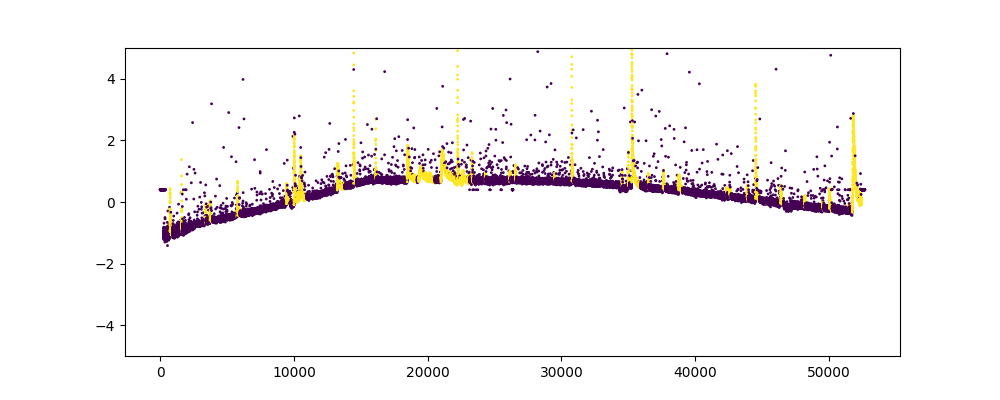

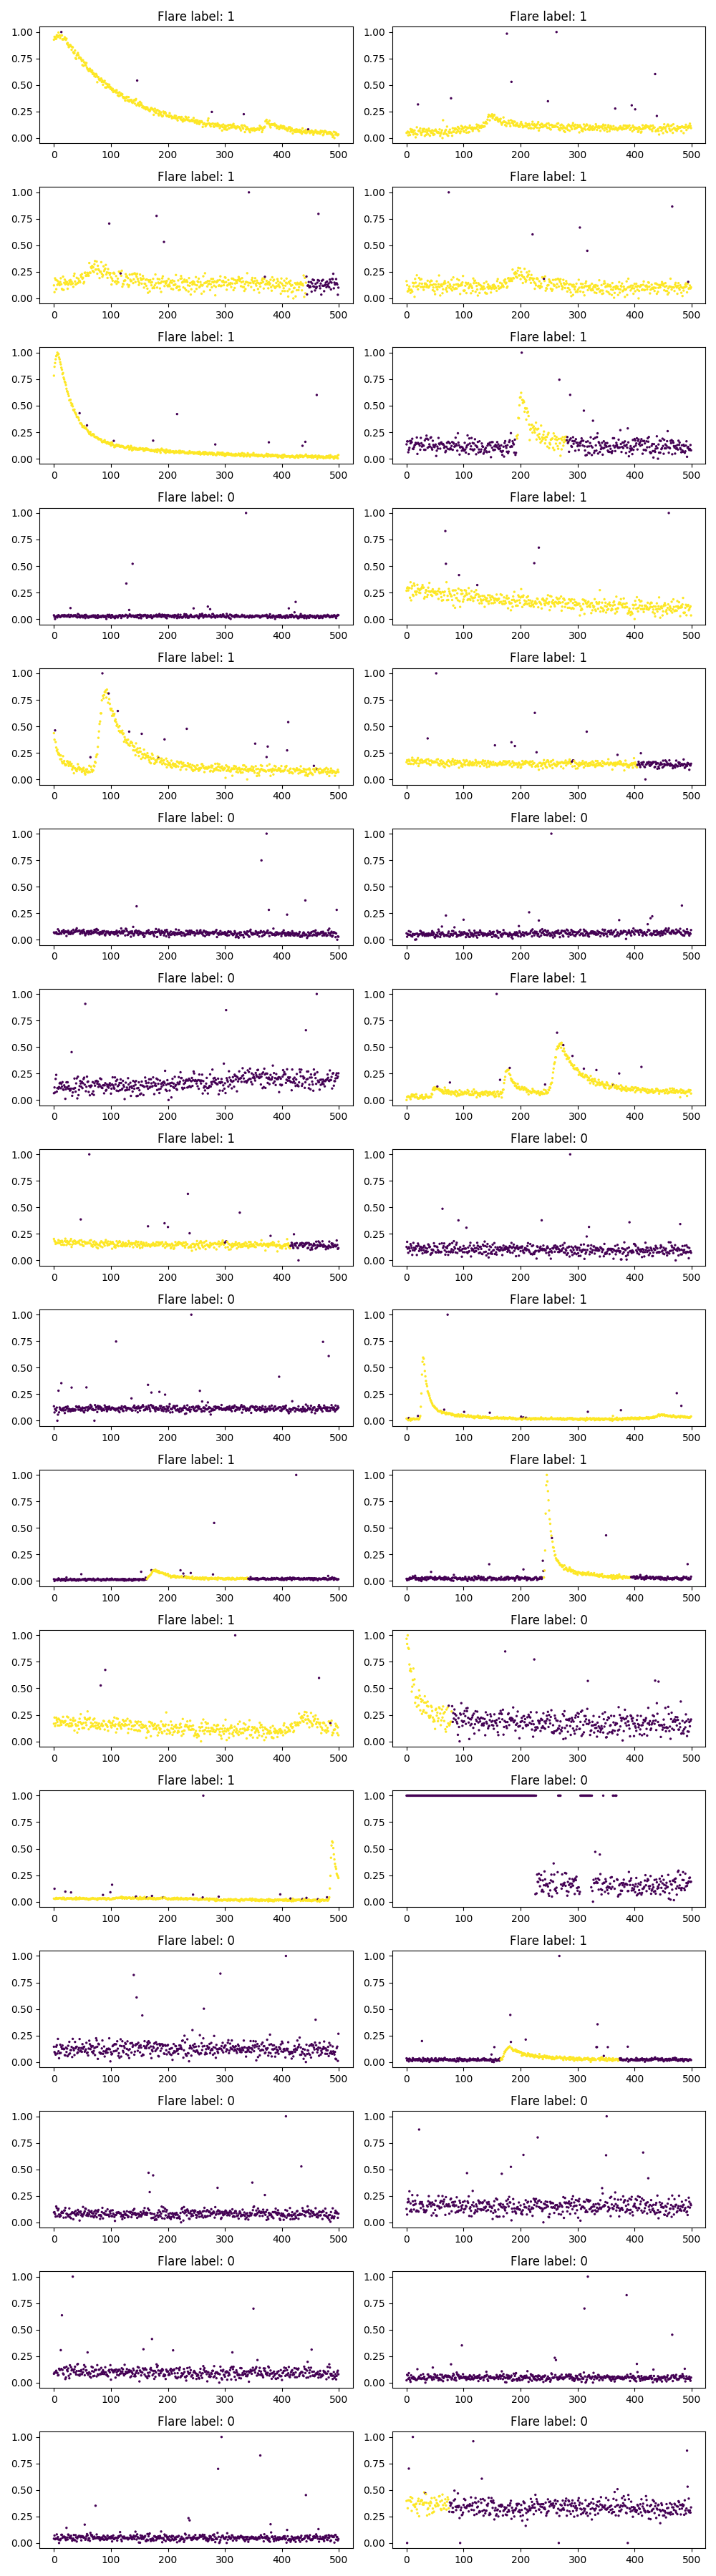

In [151]:
fn.visualize_input()

In [152]:
fn.build_nn_model()
history = fn.train_model(epochs=1)
fn.model.save('alpha_test/alpha_test_minmaxscaling_model.keras')

Generating new nn model


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputA (InputLayer)             │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_120 (Conv1D)             │ (None, 500, 16)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_121 (Conv1D)             │ (None, 500, 16)        │         3,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_122 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_123 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_124 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_125 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 500, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │       512,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,633 (2.01 MB)

 Trainable params: 527,601 (2.01 MB)

 Non-trainable params: 32 (128.00 B)

None


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


44823/44823 ━━━━━━━━━━━━━━━━━━━━ 865s 19ms/step - accuracy: 0.8331 - loss: 0.3715


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [153]:
fn.create_prediction_dataset('flarenet/prediction_data/TIC 441420236_27_1_data.csv')
fn.predict_with_model('alpha_test/alpha_test_minmaxscaling_model.keras')

Making predictions for flarenet/prediction_data/TIC 441420236_27_1_data.csv 
Loading model from alpha_test/alpha_test_minmaxscaling_model.keras
    117/Unknown 0s 891us/step

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


51196/51196 ━━━━━━━━━━━━━━━━━━━━ 44s 861us/step


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


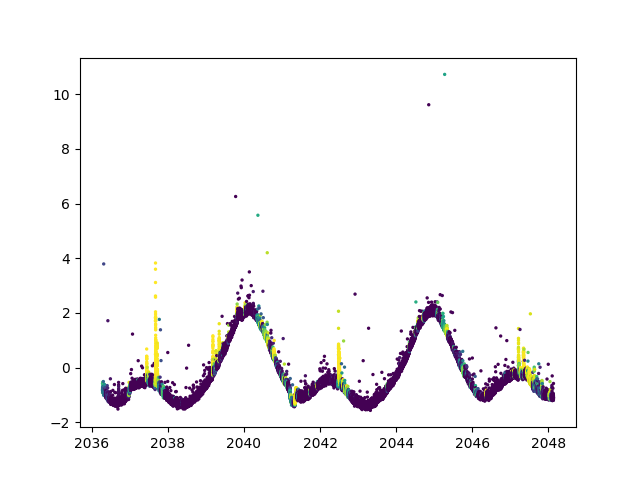

In [154]:
pred_data = pd.read_csv(fn.prediction_file)
plt.figure()
plt.scatter(pred_data['time'].values[250:-250], pred_data['normalized_flux'].values[250:-250], c=fn.preds, s=2)
plt.show()

# Train a basic model with Robust Scaling

In [155]:
window_size=500
fn = flarenet.flarenet(verbose=False,
                      scaling = "Robust",)
fn.create_training_dataset(data_dir = 'training_data/injected_flares',
                                drop_frac=0.5, 
                                )
fn.training_files[:10]

Found 120 training files


['/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 38846515_34_2_data_rrlyrae.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 229747848_56_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 219780306_56_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 150064391_34_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 233682504_53_2_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 1758607_46_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149990841_39_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149059708_29_1_data_pulsations.csv',
 '/U

Samples of minority class samples: 5105
Total Samples: 52182
Valid indices: 10210


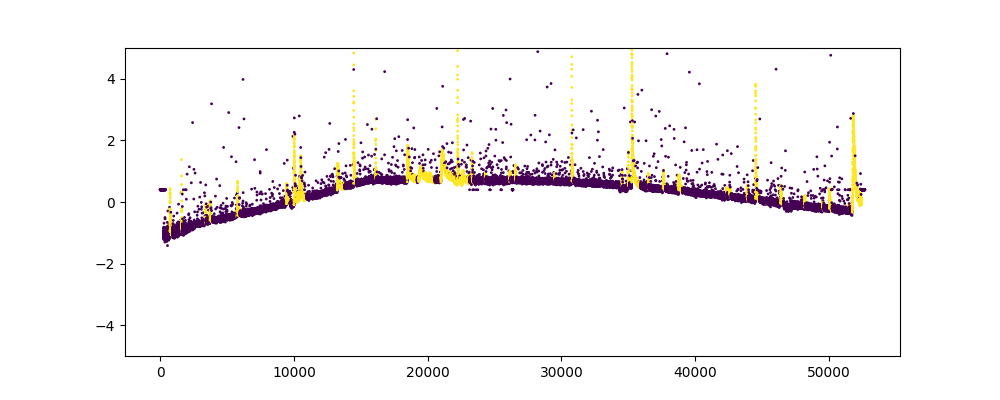

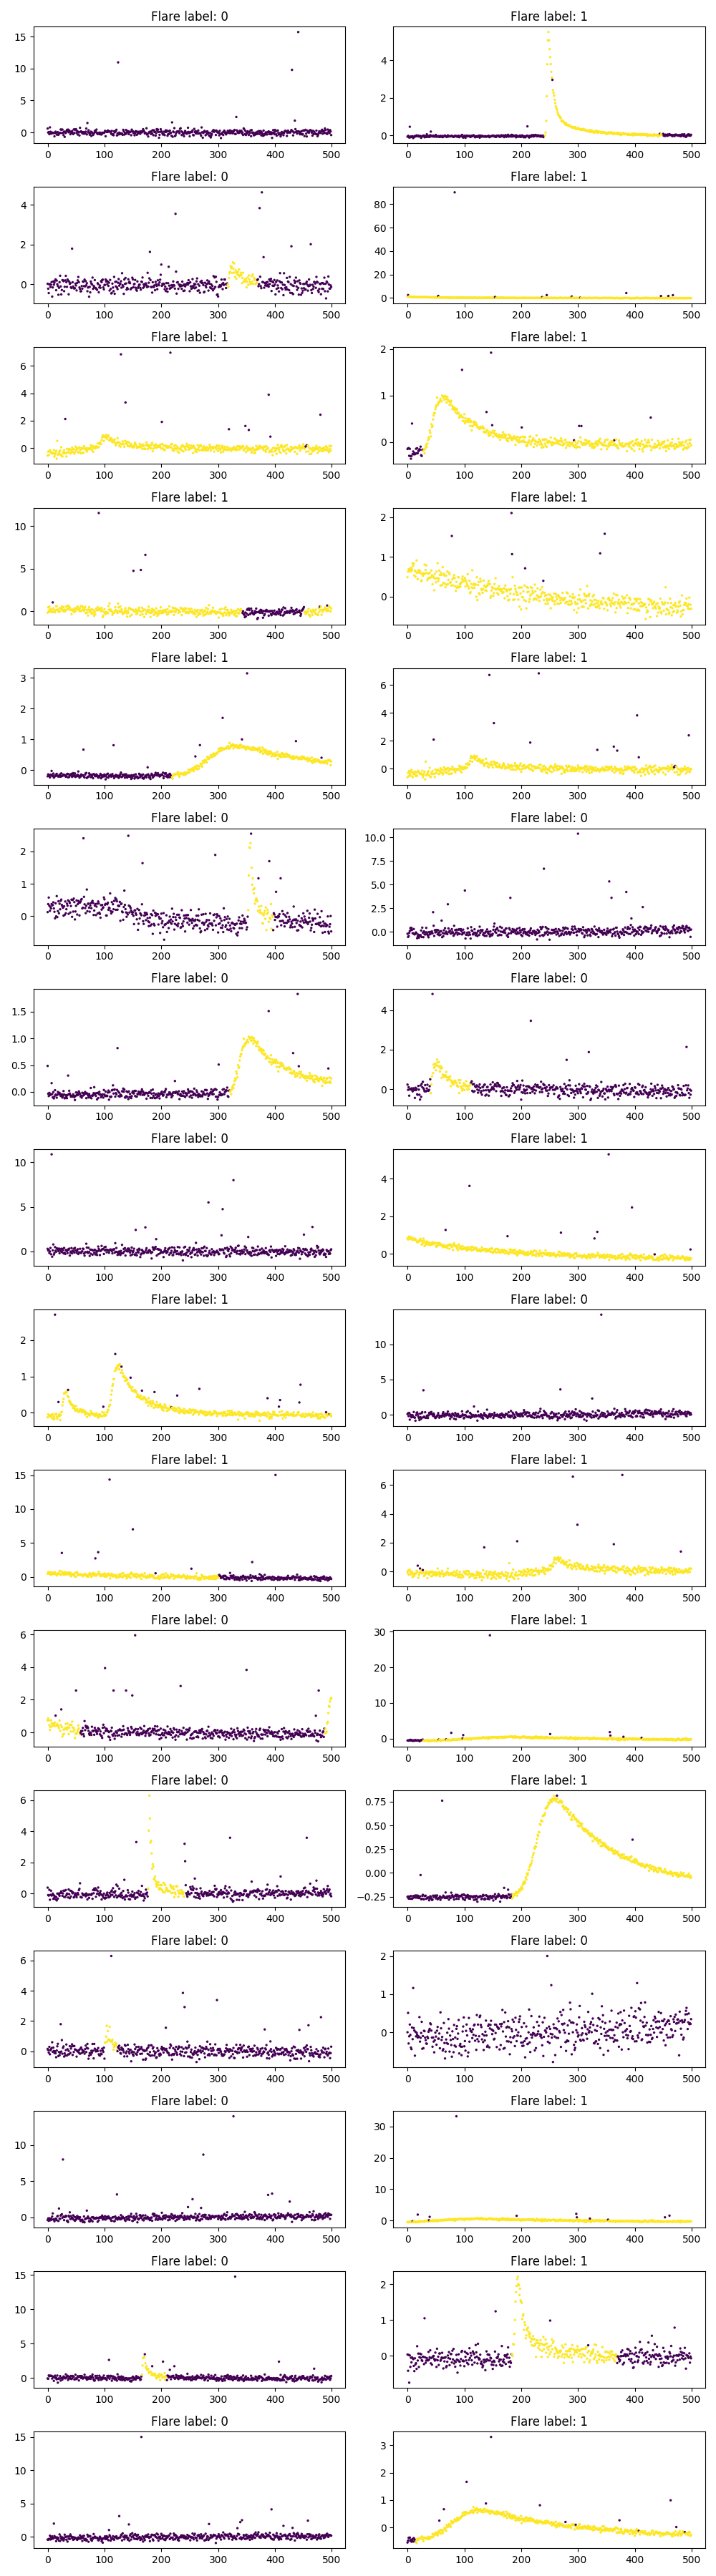

In [156]:
fn.visualize_input()

In [157]:
fn.build_nn_model()
history = fn.train_model(epochs=1)
fn.model.save('alpha_test/alpha_test_robustscaling_model.keras')

Generating new nn model


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputA (InputLayer)             │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_132 (Conv1D)             │ (None, 500, 16)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_133 (Conv1D)             │ (None, 500, 16)        │         3,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_134 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_135 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_136 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_137 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 500, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │       512,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,633 (2.01 MB)

 Trainable params: 527,601 (2.01 MB)

 Non-trainable params: 32 (128.00 B)

None


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


44823/44823 ━━━━━━━━━━━━━━━━━━━━ 871s 19ms/step - accuracy: 0.8462 - loss: 0.3491


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [158]:
fn.create_prediction_dataset('flarenet/prediction_data/TIC 441420236_27_1_data.csv')
fn.predict_with_model('alpha_test/alpha_test_robustscaling_model.keras')

Making predictions for flarenet/prediction_data/TIC 441420236_27_1_data.csv 
Loading model from alpha_test/alpha_test_robustscaling_model.keras
    108/Unknown 0s 985us/step

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


51196/51196 ━━━━━━━━━━━━━━━━━━━━ 46s 895us/step


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


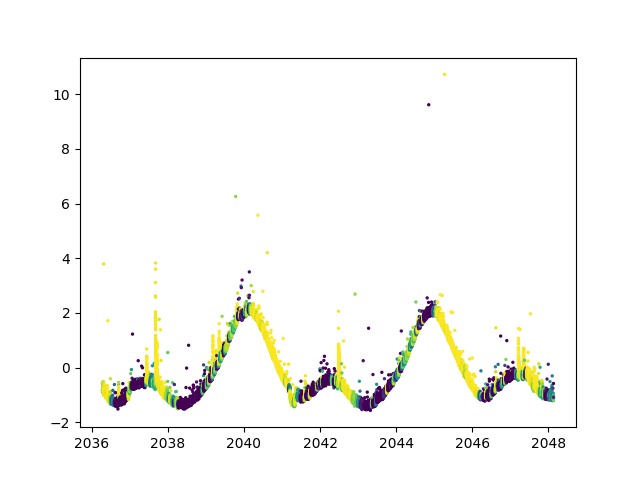

In [159]:
pred_data = pd.read_csv(fn.prediction_file)
plt.figure()
plt.scatter(pred_data['time'].values[250:-250], pred_data['normalized_flux'].values[250:-250], c=fn.preds, s=2)
plt.show()

# Fit a basic model with Quantile Scaling

In [174]:
window_size=500
fn = flarenet.flarenet(verbose=False,
                      scaling = "Quantile",)
fn.create_training_dataset(data_dir = 'training_data/injected_flares',
                                drop_frac=0.5, 
                                )
fn.training_files[:10]

Found 120 training files


['/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 38846515_34_2_data_rrlyrae.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 229747848_56_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 219780306_56_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 150064391_34_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 233682504_53_2_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 1758607_46_1_data_pulsations.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149990841_39_2_data.csv',
 '/Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/training_data/injected_flares/TIC 149059708_29_1_data_pulsations.csv',
 '/U

Samples of minority class samples: 5105
Total Samples: 52182
Valid indices: 10210


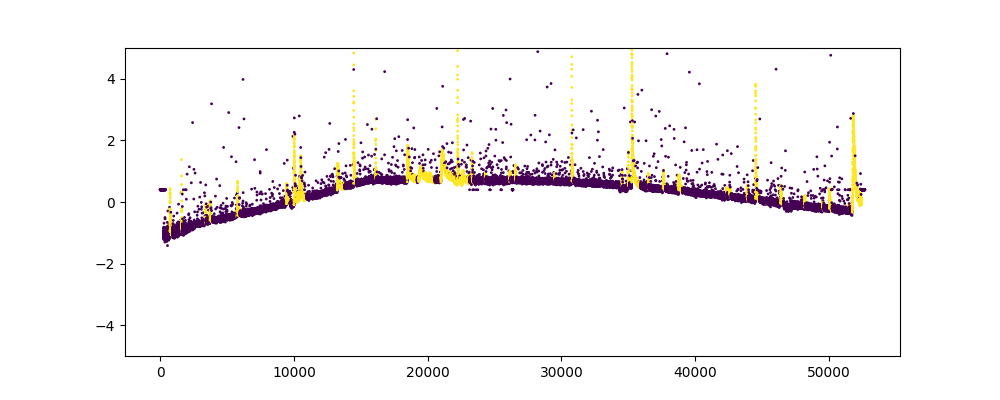

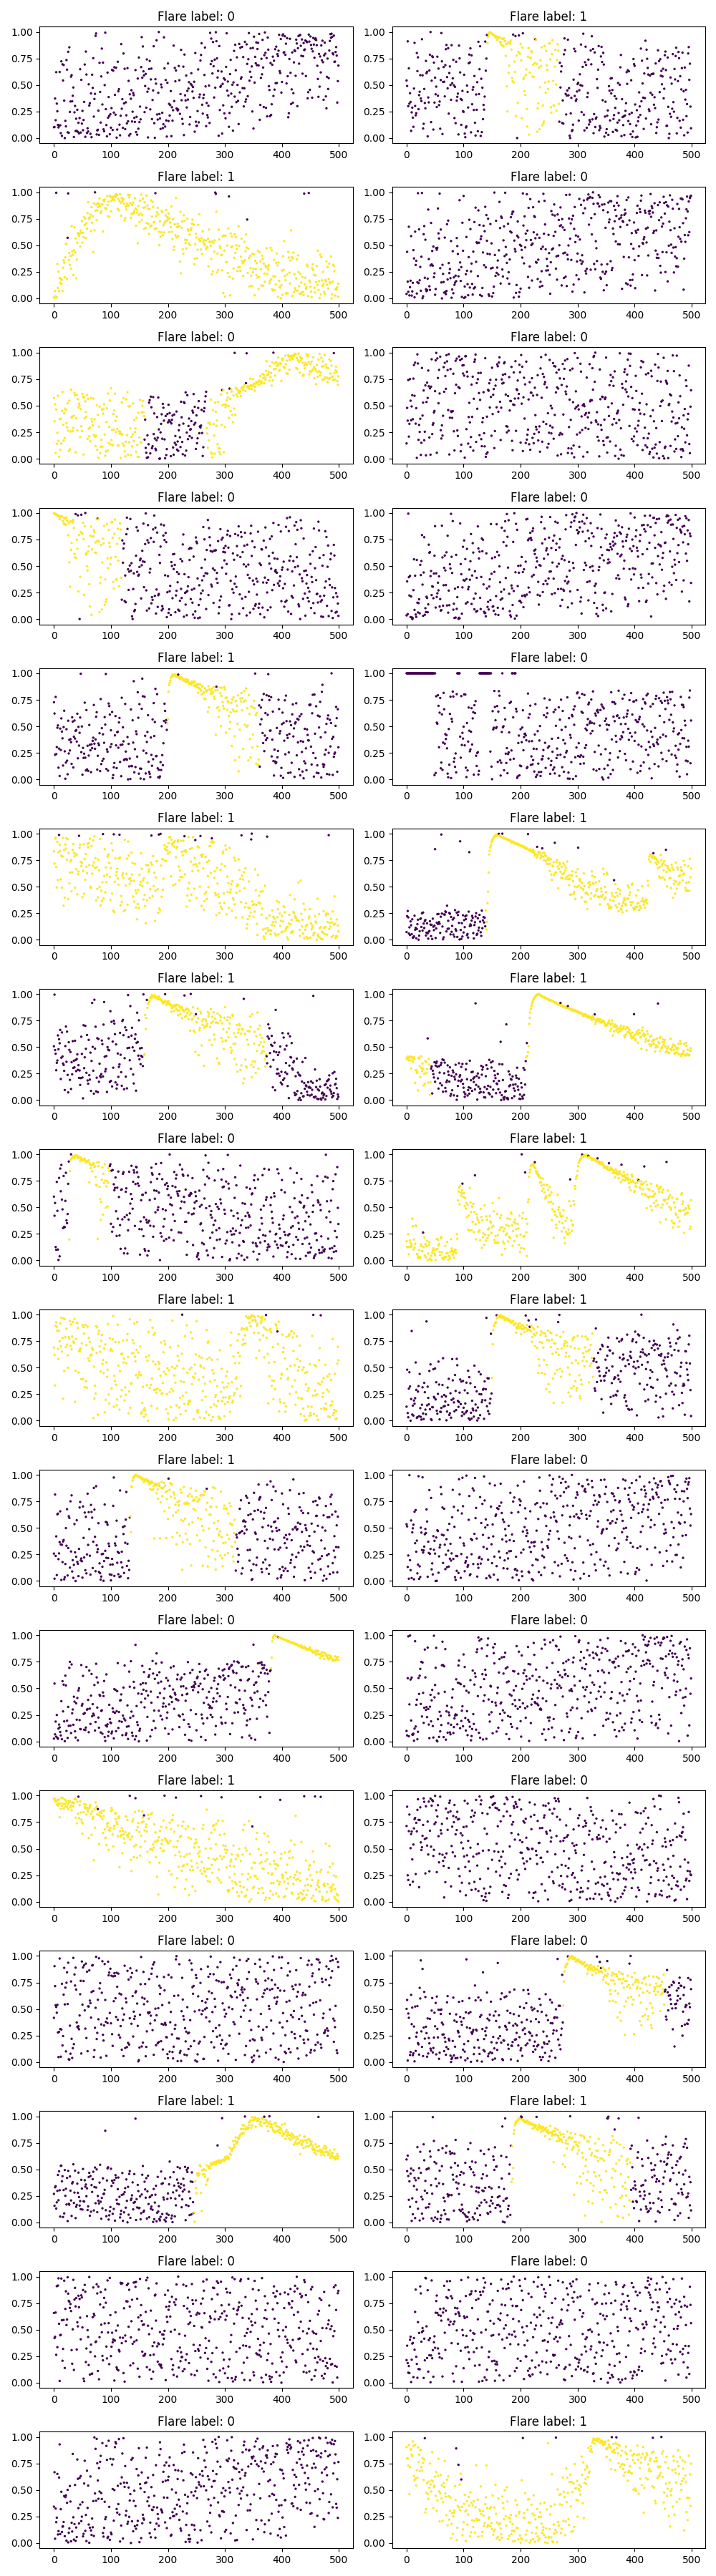

In [175]:
fn.visualize_input()

In [176]:
fn.build_nn_model()
history = fn.train_model(epochs=1)
fn.model.save('alpha_test/alpha_test_quantilescaling_model.keras')

Generating new nn model


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputA (InputLayer)             │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_150 (Conv1D)             │ (None, 500, 16)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_151 (Conv1D)             │ (None, 500, 16)        │         3,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_152 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_153 (Conv1D)             │ (None, 500, 16)        │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_154 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_155 (Conv1D)             │ (None, 500, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 500, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 64)             │       512,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,633 (2.01 MB)

 Trainable params: 527,601 (2.01 MB)

 Non-trainable params: 32 (128.00 B)

None


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


44823/44823 ━━━━━━━━━━━━━━━━━━━━ 1460s 33ms/step - accuracy: 0.8572 - loss: 0.3189


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [177]:
fn.create_prediction_dataset('flarenet/prediction_data/TIC 441420236_27_1_data.csv')
fn.predict_with_model('alpha_test/alpha_test_quantilescaling_model.keras')

Making predictions for flarenet/prediction_data/TIC 441420236_27_1_data.csv 
Loading model from alpha_test/alpha_test_quantilescaling_model.keras
     72/Unknown 0s 1ms/step 

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: inputA. Received: the structure of inputs={'inputA': '*'}
  warnings.warn(


51196/51196 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step


/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2025-02-04 16:54:40.001120: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


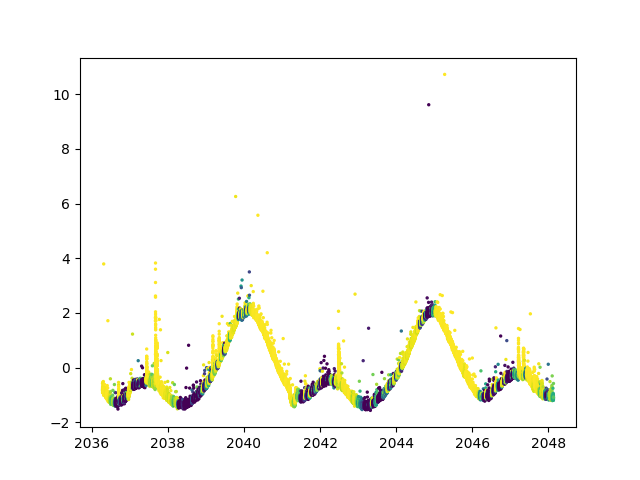

In [178]:
pred_data = pd.read_csv(fn.prediction_file)
plt.figure()
plt.scatter(pred_data['time'].values[250:-250], pred_data['normalized_flux'].values[250:-250], c=fn.preds, s=2)
plt.show()

# Just playing around with Brian's pulsation and ll lyrae functions before implementing them

In [19]:

pred_data

Unnamed: 0         time          flux    flux_err  quality  crArr  \
0             498  2036.225813  266638.71875  121.158333    128.0    0.0   
1             496  2036.226045  266638.71875  121.158333    128.0    0.0   
2             494  2036.226276  266638.71875  121.158333    128.0    0.0   
3             492  2036.226508  266638.71875  121.158333    128.0    0.0   
4             490  2036.226739  266638.71875  121.158333    128.0    0.0   
...           ...          ...           ...         ...      ...    ...   
51691         491  2048.191157  266638.71875  121.158333    128.0    0.0   
51692         493  2048.191389  266638.71875  121.158333    128.0    0.0   
51693         495  2048.191620  266638.71875  121.158333    128.0    0.0   
51694         497  2048.191852  266638.71875  121.158333    128.0    0.0   
51695         499  2048.192083  266638.71875  121.158333    128.0    0.0   

       normalized_flux  filled  flareArr  
0            -0.582798     1.0       0.0  
1            -0.582798     1.0       0.0  
2            -0.582798     1.0       0.0  
3            -0.582798     1.0       0.0  
4            -0.582798     1.0       0.0  
...                ...     ...       ...  
51691        -0.582798     1.0       0.0  
51692        -0.582798     1.0       0.0  
51693        -0.582798     1.0       0.0  
51694        -0.582798     1.0       0.0  
51695        -0.582798     1.0       0.0  

[51696 rows x 9 columns]

In [61]:
def stellar_pulsations(t):
    periods = np.random.uniform(0.1, 5, size=3)
    amplitudes = np.random.uniform(0.01, 0.1, size=3)
    phases = np.random.uniform(0, 2*np.pi, size=3)

    signal = np.zeros_like(t)
    for period, amplitude, phase in zip(periods, amplitudes, phases):
        signal += amplitude * np.sin(2 * np.pi * (t / period + phase))
    #signal = signal
    signal /= (1 + np.median(signal))
    return signal



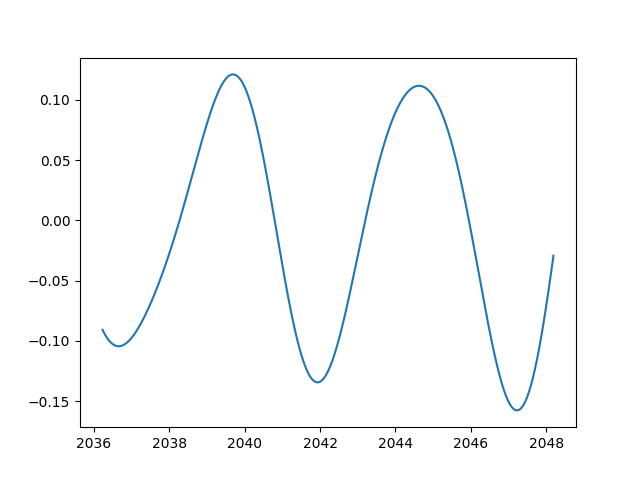

In [64]:
s = stellar_pulsations(pred_data['time'].values)
plt.figure()
plt.plot(pred_data['time'].values, s)
plt.show()


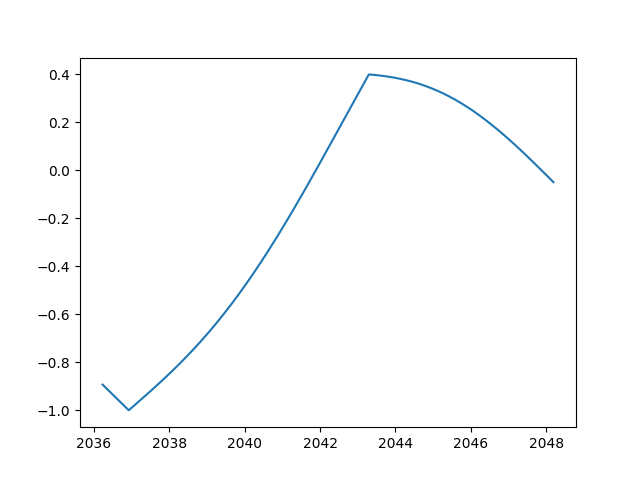

In [60]:
def rr_lyrae(t):
    """
    Simulate an RR Lyrae variable star light curve.
    Parameters:
    t (array): Time array
    period (float): Pulsation period in days
    amplitude (float): Amplitude of the variation
    rise_fraction (float): Fraction of the period spent in the rising phase
    phase_offset (float): Phase offset for the pulsation
    Returns:
    array: Simulated RR Lyrae light curve
    """
    period =  np.random.uniform(0.5, 35),
    amplitude = np.random.uniform(0.1, 0.5)
    rise_fraction = np.random.uniform(0.1, 0.3)
    phase_offset = np.random.uniform(0, 1)

    
    phase = ((t / period) + phase_offset) % 1
    signal = np.zeros_like(t)
    # Rising phase (usually steeper)
    rising = phase < rise_fraction
    signal[rising] = amplitude * (phase[rising] / rise_fraction)
    # Falling phase
    falling = ~rising
    signal[falling] = amplitude * (1 - ((phase[falling] - rise_fraction) / (1 - rise_fraction)))
    # Add some asymmetry and non-linearity to make it more realistic
    signal = signal - 0.1 * amplitude * np.sin(4 * np.pi * phase)
    # Normalize around 1
    signal /= np.median(signal)
    return signal - 1

# https://www.sciencedirect.com/topics/physics-and-astronomy/rr-lyrae-variable-stars#:~:text=IV.,-A.&text=They%20range%20in%20period%20from,range%200.3%20to%201%20magnitude.
# They range in period from 0.5 to 35 days and have amplitudes in the range 0.3 to 1 magnitude.

s = rr_lyrae(pred_data['time'].values)
plt.figure()
plt.plot(pred_data['time'].values, s)
plt.show()


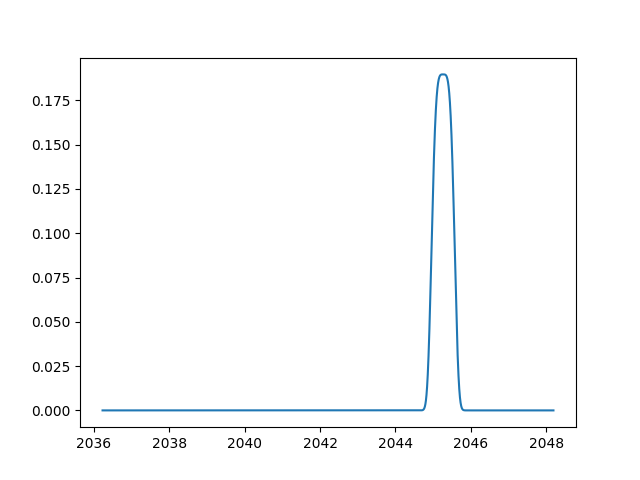

In [23]:
def asteroid_sim(t):
    """
    Simulate an asteroid passing in front of a star in TESS.
    Parameters:
    t (array): Time array
    """
    # Ranges loosely based on https://iopscience.iop.org/article/10.3847/1538-4357/ace9df
    amp = np.random.uniform(0.01, 0.2)
    sig = np.random.uniform(0.01, .2)
    t_mid = np.random.choice(t)
    
    #signal = amp * np.exp(-((t - t_mid) ** 2) / (2 * sig ** 2)) # Regular gaussian
    # Make a 'flat-top' gaussian instead
    signal = amp * np.exp(-((t - t_mid) / (2 * sig))**4)
    #print(t_mid, amp, sig)
    return signal




s = asteroid_sim(pred_data['time'].values)
plt.figure()
plt.plot(pred_data['time'].values, s)
plt.show()


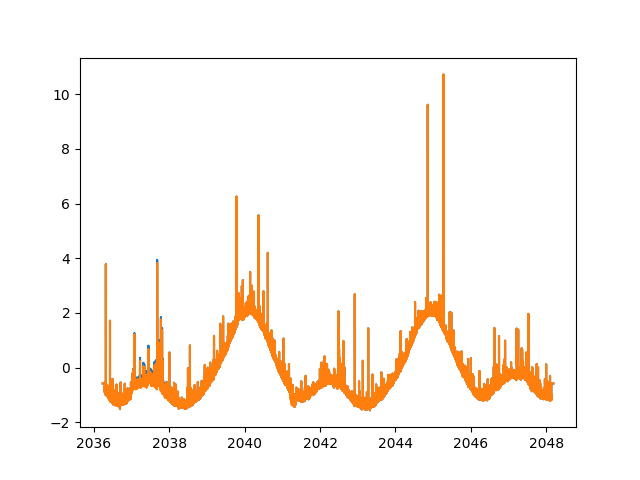

In [41]:
s = asteroid_sim(pred_data['time'].values)
plt.figure()
plt.plot(pred_data['time'].values, pred_data['normalized_flux'].values+s)
plt.plot(pred_data['time'].values, pred_data['normalized_flux'].values)

plt.show()

In [49]:
def stellar_activity(t):
    periods = np.random.uniform(0.1, 27, size=2)
    amplitudes = np.random.uniform(0.01, 3, size=2)
    phases = np.random.uniform(0, 2*np.pi, size=2)

    signal = np.zeros_like(t)
    for period, amplitude, phase in zip(periods, amplitudes, phases):
        signal += amplitude * np.sin(2 * np.pi * (t / period + phase))
    #signal = signal
    signal /= (1 + np.median(signal))
    return signal

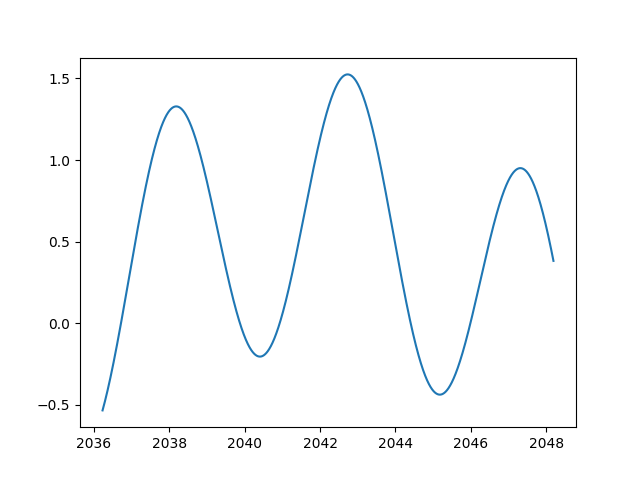

In [50]:
s = stellar_activity(pred_data['time'].values)
plt.figure()
plt.plot(pred_data['time'].values, s)
plt.show()